In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


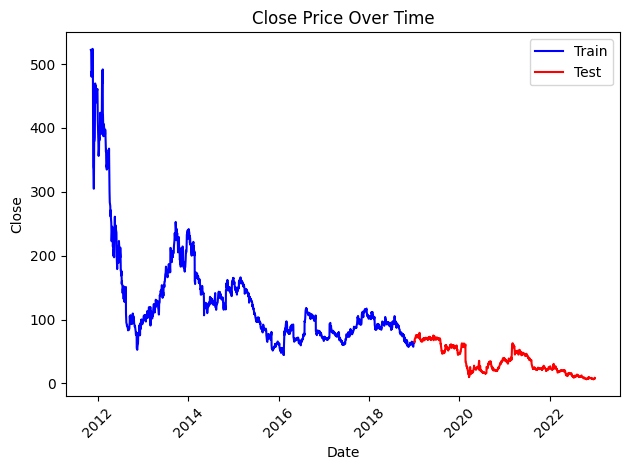

In [2]:
#AAPL
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
data = Data('GRPN',start_date,end_date,2019)
data.data_preprocess()

In [3]:

ga = IslandGGA(data=data.train_data,K=4,num_islands=8,m_iter=10,num_iter=100,pSize=100,r_cross=0.4,r_mut=0.1,strategies=data.strategies,evolve_strategy="ring")
ga.evolve()

Running ring
GENERATION 0 START
Generation 0: Best fitness = 0.7804126670778333 Average Fitness = 0.4484423144025451
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 0.7804126670778333 Average Fitness = 0.4843458721893956
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 0.9571268477720577 Average Fitness = 0.5374440706275924
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 0.9571268477720577 Average Fitness = 0.584784276644449
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 0.9809380875301372 Average Fitness = 0.6286759484534028
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 0.9809380875301372 Average Fitness = 0.6501259246121571
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 1.0903816651522433 Average Fitness = 0.6878738158267027
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 1.0903816651522433 Average Fitness = 0.7175597989441377
GENERATION 7 END
GENERATION 8 START
G

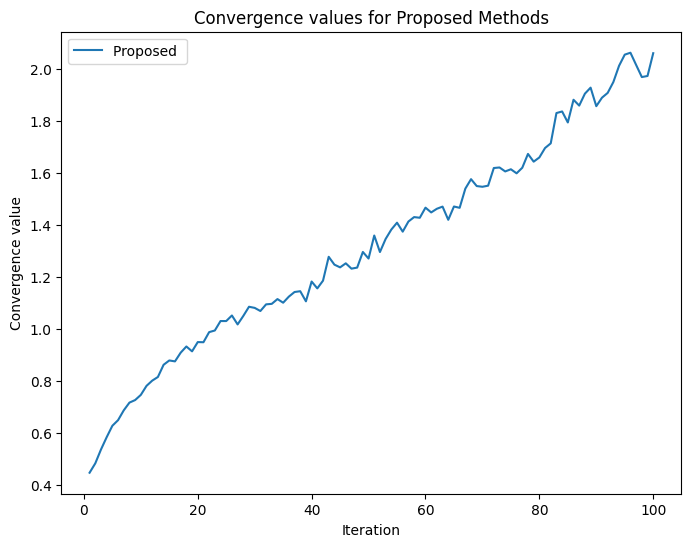

In [4]:
# Plot the convergence values for each evolutionary strategy
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 101), ga.convergence_values, label='Proposed ')
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for Proposed Methods')
plt.legend()
plt.show()

In [24]:
b = ga.globalBest
ts_data = b.strategy_performance(data.train_data)
def getProfit(self, ts_data, allocated_capital):
        weights = self.weight_part
        total = 0
        normalised_total = 0
        # Calculate profits for each trading strategy
        ts_profits = (1 + ts_data).cumprod().iloc[-1] - 1
        normalized_profits = (ts_profits - ts_profits.min()) / (ts_profits.max() - ts_profits.min())
        
        for i, group in enumerate(self.group_part):
            if len(group) !=0:
                if weights[i] != 0:
                    group_profits = ts_profits[group]
                    
                    # Calculate contributions for the original values
                    contribution = group_profits * weights[i] * allocated_capital
                    self.bbb = contribution
                    total += contribution.mean()
                    
                    # Normalize profits and calculate contributions
                    #normalized_profits = (group_profits - group_profits.min()) / (group_profits.max() - group_profits.min())
                    normalized_contribution = normalized_profits[group] * weights[i] * allocated_capital
                    normalised_total += normalized_contribution.mean() 
        return total, normalised_total
getProfit(b,ts_data,1)


(0.22142943332770976, 0.5647258123291783)

In [28]:
import numpy as np
import pandas as pd


def strategy_performance(data):
    strategy_performance = {}
    for strategy in b.strategies:
        strategy_performance[strategy] =  b.generate_trading_signal(data,strategy,-1,1)
    strategy_performance = pd.DataFrame.from_dict(strategy_performance)
    return strategy_performance
# Monthly returns DataFrame for each asset
monthly_returns = strategy_performance(data.train_data)

# Divide assets into four groups (manually or programmatically)
groups = [
    ["TS1", "TS2","TS3"],  # Assets in group 1
    ["TS4", "TS5", "TS6"],  # Assets in group 2
    ["TS7", "TS8", "TS9"],  # Assets in group 3
    ["TS10", "TS11","TS12"]   # Assets in group 4
]

# Calculate cumulative returns for each group
group_cumulative_returns = []
for group_assets in groups:

    group_returns = monthly_returns[group_assets]
    group_cumulative_returns.append((1 + group_returns).cumprod())

# Calculate mean cumulative return for each group
group_mean_cumulative_returns = [
    group_cumulative_return.mean(axis=1)
    for group_cumulative_return in group_cumulative_returns
]

# Assign equal weights to each group
group_weights = [1 / len(groups)] * len(groups)

# Calculate portfolio performance
portfolio_mean_cumulative_return = np.mean(group_mean_cumulative_returns)

portfolio_mean_cumulative_return 

0.4155203500829399

In [31]:
import numpy as np
import pandas as pd


def strategy_performance(data):
    strategy_performance = {}
    for strategy in b.strategies:
        strategy_performance[strategy] =  b.generate_trading_signal(data,strategy,-1,1)
    strategy_performance = pd.DataFrame.from_dict(strategy_performance)
    return strategy_performance
# Monthly returns DataFrame for each asset
monthly_returns = strategy_performance(data.train_data)

# Divide assets into four groups (manually or programmatically)
groups = [
    ["TS1", "TS2","TS3"],  # Assets in group 1
    ["TS4", "TS5", "TS6"],  # Assets in group 2
    ["TS7", "TS8", "TS9"],  # Assets in group 3
    ["TS10", "TS11","TS12"]   # Assets in group 4
]
# Calculate Maximum Drawdown (MDD) for each group
group_mdds = []
for group_assets in groups:
    group_returns = monthly_returns[group_assets]
    cumulative_returns = (1 + group_returns).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_max - cumulative_returns
    max_drawdown = drawdown.max()
    group_mdds.append(max_drawdown)

# Calculate mean Maximum Drawdown (MDD) for all groups
mean_mdd = np.mean(group_mdds)


mean_mdd

0.8256766999743

In [32]:
b.mdd

0.058721805255732076

In [29]:
asset_prices = data.train_data.copy()
# Set the 'Date' column as the index of the DataFrame if it's not already
asset_prices.set_index('Date', inplace=True)

# Resample the asset prices to monthly frequency and select the first and last values of each month
monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

# Calculate the monthly returns as the percentage change in price
monthly_returns = monthly_prices['close', 'last'].pct_change()

# Calculate the cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
profit = cumulative_returns.iloc[-1]-1

print("Profit for the Buy-and-Hold Strategy:")
print(profit)
print("Profit for the gtspo Strategy:")
print(ga.globalBest.profit)
# Plot the monthly returns
#monthly_returns.plot(figsize=(10, 6))
print(ga.globalBest)

Profit for the Buy-and-Hold Strategy:
-0.8171428571428571
Profit for the gtspo Strategy:
0.22142943332770976
SLTP: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
GROUP: [['TS1', 'TS5', 'TS8', 'TS6'], ['TS4', 'TS10', 'TS9', 'TS3'], ['TS7', 'TS2'], ['TS11', 'TS12']]
WEIGHT: [0.0, 0.34, 0.08, 0.58]
FITNESS: 3.5960121975466164


In [ ]:

def max_drawdown(returns):
  """
  Calculates the maximum drawdown from monthly returns.

  Args:
    returns: A pandas DataFrame of monthly returns.

  Returns:
    The maximum drawdown.
  """

  # Calculate the cumulative returns.
  cumulative_returns = (1 + returns).cumprod()

  # Find the minimum value of the cumulative returns.
  min_return = cumulative_returns.min()

  # Calculate the maximum drawdown.
  max_drawdown = (1 - min_return) 

  return max_drawdown

if __name__ == "__main__":
  # Load the monthly returns data.
  asset_prices = data.train_data.copy()
  # Set the 'Date' column as the index of the DataFrame if it's not already
  asset_prices.set_index('Date', inplace=True)

  # Resample the asset prices to monthly frequency and select the first and last values of each month
  monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

  # Calculate the monthly returns as the percentage change in price
  monthly_returns = monthly_prices['close', 'last'].pct_change()

  # Calculate the maximum drawdown.
  max_drawdown = max_drawdown(monthly_returns)

  # Print the maximum drawdown.
  print(f"The maximum drawdown is {max_drawdown:.2f}.")
  print("Profit for the gtspo Strategy:")
print(ga.globalBest.mdd)
